Implementation of http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html?highlight=mnist

In [1]:
import model
from model import *
import utils
from utils import *

BATCH_SIZE = 256

In [2]:
if not os.path.isfile('pokelist'):
    if os.path.exists('./Pokemon') and os.path.exists('./PokemonFlip'):
        with open("pokelist", 'w') as myfile:
            wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
            data = [os.path.abspath("./Pokemon/")+"/"+file for file in os.listdir("./Pokemon/")]
            data += [os.path.abspath("./PokemonFlip/")+"/"+file for file in os.listdir("./PokemonFlip/")]
            wr.writerow(data)
        print("Generated list of Pokemon image paths, both normal and flipped")
    elif os.path.exists('./Pokemon'):
        with open("pokelist", 'w') as myfile:
            wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
            data = [os.path.abspath("./Pokemon/")+"/"+file for file in os.listdir("./Pokemon/")]
            wr.writerow(data)
        print("Generated list of Pokemon image paths")
    else:
        print("Missing Pokemon folder with images")
else:
    print("Pokemon image list available")

Pokemon image list available


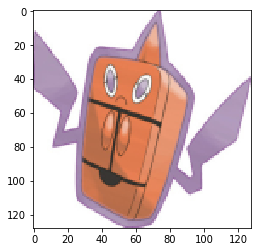

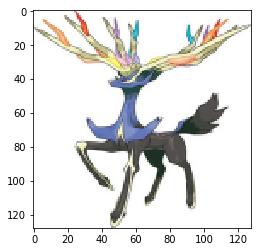

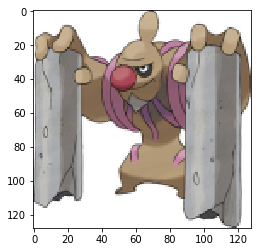

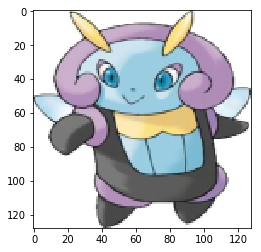

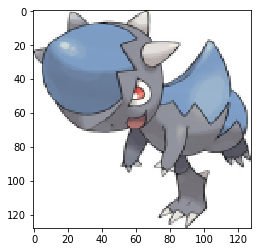

In [3]:
multiSet = MultiSet('pokemon')
dataLoader = Utils.DataLoader(dataset=multiSet, shuffle=True, batch_size=1)

for i, data in enumerate(dataLoader):
    if i in range(5):
        plt.imshow(data[0,:,:,:].squeeze().numpy())
        plt.show()

Epoch: 12 - Loss: 2703.060303


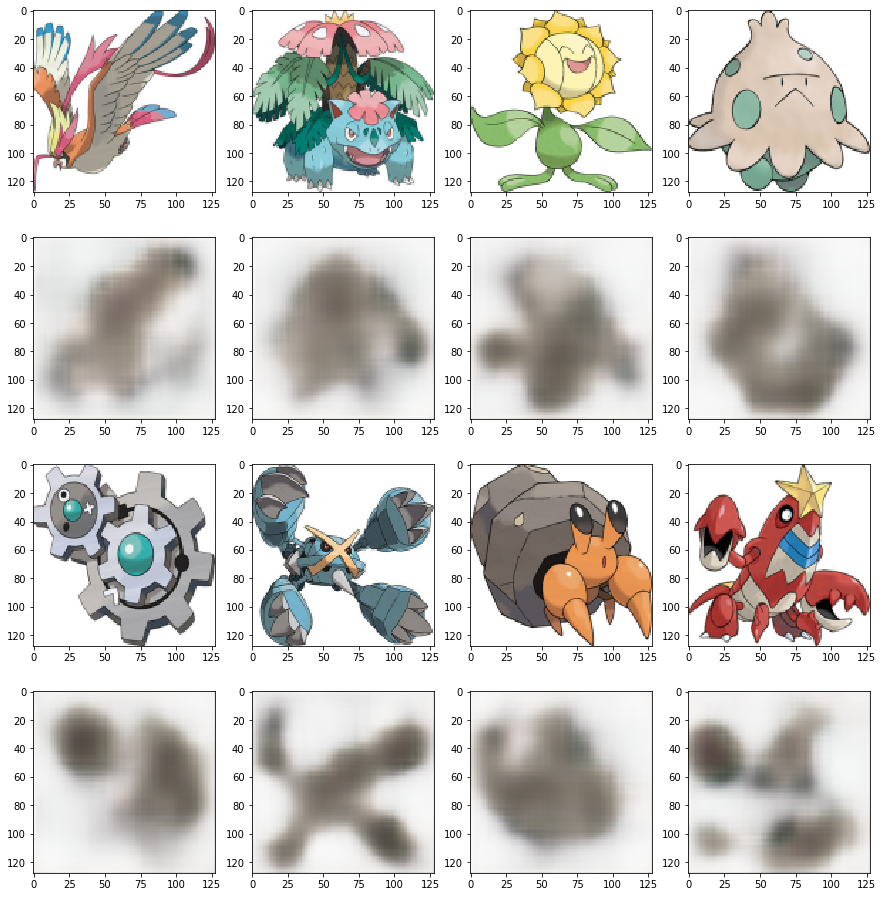

KeyboardInterrupt: 

In [4]:
try:
    net, epoch, losses, bces, kls, optimizer = load_checkpoint("./checkpoints/")
except:
    net = Net() # Initialize model
    if torch.cuda.is_available():
        if torch.cuda.device_count() > 1:
            net = torch.nn.DataParallel(net)
        net = net.cuda() 
    epoch = 0
    losses = []
    bces = []
    kls = []
    optimizer = optim.Adam(net.parameters(), lr=0.001, amsgrad=True)
    scheduler = SGDRScheduler(optimizer, min_lr=1e-5, max_lr=1e-3, cycle_length=500, current_step=0)
    print("Starting new training")

max_epochs = 5000

multiSet = MultiSet('pokemon')
dataLoader = Utils.DataLoader(dataset=multiSet, shuffle=True, batch_size=BATCH_SIZE)

train_losses, bces, kls = train(net, optimizer, scheduler, dataLoader, epoch, "POKEVAE", losses, bces, kls, max_epochs)
plt.figure(figsize=(10,5))
plt.plot(train_losses)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(bces)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(kls)
plt.show()

In [ ]:
dataiter = iter(dataLoader)

image = dataiter.next()
image = image[0,:,:,:].unsqueeze(0)
plt.imshow((image.squeeze().numpy()))
plt.show()
image = image.permute(0,3,1,2)
x_out, z_mean, z_logvar = net(Variable(image.float()))
x_out = x_out.permute(0,2,3,1)
plt.imshow(x_out.data.squeeze().numpy())
plt.show()
z = net.latent(z_mean, z_logvar)

In [ ]:
def sweep(image, dim, min_range, max_range, step):
    z_mean, z_logvar = net.encoder(Variable(image.permute(0,3,1,2).float().cuda()))
    z = net.latent(z_mean,z_logvar)
    for i in range(min_range, max_range, step):
        z[0][dim] = sw
        x_out = net.decoder(z)
        im = np.floor(x_out.permute(0,2,3,1).data.cpu().squeeze().numpy()*255).astype(np.uint8)
        plt.imsave("./sweep/" + str(dim) + "/" + "{0:03d}".format(i) + ".png", im)
    generate_animation("./sweep/" + str(dim) + "/", dim, (max_range - min_range)//step)

In [ ]:
sweep(image, 99, -15, 15, 1)

In [ ]:
# Visualize moving average of losses
def visualize_losses_moving_average(losses,window=50,boundary='valid'):
    mav_losses = np.convolve(losses,np.ones(window)/window,boundary)
    corrected_mav_losses = np.append(np.full(window-1,np.nan),mav_losses)
    plt.figure(figsize=(10,5))
    plt.plot(losses)
    plt.plot(corrected_mav_losses)
    plt.ylim(ylim)
    plt.show()

visualize_losses_moving_average(train_losses)

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, _ = data

        # wrap them in Variable
        inputs = Variable(inputs)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        x_out, z_mean, z_logvar = net(inputs)
        loss = criterion(x_out, inputs, z_mean, z_logvar)
        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

#### Testing Network

In [ ]:
pokemon = mpimg.imread("./Pokemon/marowak.jpg")
pokemon = cv2.resize(pokemon, (RESIZE,RESIZE))
pokemon = (pokemon - np.min(pokemon))/np.max(pokemon - np.min(pokemon))
image = torch.from_numpy(pokemon).unsqueeze(0)

image = image[0,:,:,:].unsqueeze(0)
plt.imshow((image.squeeze().numpy()))
plt.show()
image = image.permute(0,3,1,2)
x_out, z_mean, z_logvar = net(Variable(image.float()).cuda())
x_out = x_out.permute(0,2,3,1)
plt.imshow(x_out.data.cpu().squeeze().numpy())
plt.show()
z = net.latent(z_mean, z_logvar)
ss = net.decoder(z)
ss = ss.permute(0,2,3,1)
plt.imshow(ss.data.cpu().squeeze().numpy())
plt.show()

In [ ]:
#Test network accuracy

correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs, _, _ = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

In [ ]:
def generate_animation(path, dim, num):
    images = []
    for e in range(num):
        img_name = path + "{0:03d}".format(e) + '.png'
        images.append(mpimg.imread(img_name))
    imageio.mimsave("./sweep/gif/" + 'dim' + str(dim) + '_generate_animation.gif', images, fps=30)

In [ ]:

imageimage  ==  imageimage..permutepermute(0,2,3,1)
for i in range(256):
    os.system("mkdir ./sweep/"+str(i))
    sweep(image, i, -300, 300, 5)

In [ ]:
def interpolate_linear(path1, path2, savepath, STEP):
    pokemon = mpimg.imread(path1)
    pokemon = cv2.resize(pokemon, (RESIZE,RESIZE))
    pokemon = (pokemon - np.min(pokemon))/np.max(pokemon - np.min(pokemon))
    image = torch.from_numpy(pokemon).unsqueeze(0)

    image = image[0,:,:,:].unsqueeze(0)
    image = image.permute(0,3,1,2)
    z_mean, z_logvar = net.encoder(Variable(image.float()).cuda())
    z1 = net.latent(z_mean, z_logvar)
    ss = net.decoder(z1)
    ss = ss.permute(0,2,3,1)
    plt.imshow(ss.data.cpu().squeeze().numpy())
    plt.show()

    pokemon = mpimg.imread(path2)
    pokemon = cv2.resize(pokemon, (RESIZE,RESIZE))
    pokemon = (pokemon - np.min(pokemon))/np.max(pokemon - np.min(pokemon))
    image = torch.from_numpy(pokemon).unsqueeze(0)

    image = image[0,:,:,:].unsqueeze(0)
    image = image.permute(0,3,1,2)
    z_mean, z_logvar = net.encoder(Variable(image.float()).cuda())
    z2 = net.latent(z_mean, z_logvar)
    ss = net.decoder(z2)
    ss = ss.permute(0,2,3,1)
    plt.imshow(ss.data.cpu().squeeze().numpy())
    plt.show()
    step = (z2-z1)/STEP

    for i in range(STEP):
        ss = net.decoder(z1 + i*step)
        ss = ss.permute(0,2,3,1)
        plt.imsave(savepath + "{0:03d}".format(i) + ".png", ss.data.cpu().squeeze().numpy())

In [ ]:
def generate_animation_interpol(path, name, num):
    images = []
    for e in range(num):
        img_name = path + "{0:03d}".format(e) + '.png'
        images.append(mpimg.imread(img_name))
    imageio.mimsave("./interpolate/gif/" + name + '_generate_animation.gif', images, fps=30)

In [ ]:

STEPSTEP  ==  100100
 interpolate_linearinterpo ("./Pokemon/squirtle.jpg", "./Pokemon/charmander.jpg", "./interpolate/squirtle_charmander/", STEP)
generate_animation_interpol("./interpolate/squirtle_charmander/", "6", STEP)